In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt

In [2]:
# number of simulations per epoch
N = 16
gmx = "gmx"

# input files for grompping
mdp   = "mdrun.mdp"
topol = "topol.top"
ndx   = "index_grompp.ndx"

In [3]:
def gromacs_command(cmd, *args, input=None, **kwargs):
    """ Call the gromacs subcommand cmd. Both args and keys of kwargs should be without the leading dash.
        output is redirected to output_<cmd>.txt.
    """
    command = [gmx, cmd]+["-"+a for a in args]
    for k in kwargs:
        command += ["-"+k, kwargs[k]]
    
    with open("output_%s.txt"%cmd, "w") as fout:
        compProc = subp.run(command, stdout=fout, stderr=subp.STDOUT, input=input)
    
    return compProc.returncode

def init_rep(i):
    """ Initializes rep i
    """
    os.makedirs("epoch01/rep%02d"%i)
    
    # If not found, just load the default
    shutil.copyfile("initial/start.gro", "epoch01/rep%02d/start.gro"%i)
    print("Copied initial/start.gro to rep%02d, starting to grompp..."%i)

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch01/rep%02d"%i)

        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="1")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)

In [4]:
# Make a pdb file for mdtraj
prevdir = os.getcwd()
try:
    os.chdir("initial")

    rc = gromacs_command("trjconv", f="start.gro", s="start.gro", o="start.pdb", input=b"0\n")
    print("Process returned %d"%rc)
finally:
    os.chdir(prevdir)

Process returned 0


In [5]:
# Initial structures and first epoch
os.makedirs("epoch01", exist_ok=True)

for i in range(1,N+1):
    init_rep(i)

Copied initial/start.gro to rep01, starting to grompp...
Process returned 0
Copied initial/start.gro to rep02, starting to grompp...
Process returned 0
Copied initial/start.gro to rep03, starting to grompp...
Process returned 0
Copied initial/start.gro to rep04, starting to grompp...
Process returned 0
Copied initial/start.gro to rep05, starting to grompp...
Process returned 0
Copied initial/start.gro to rep06, starting to grompp...
Process returned 0
Copied initial/start.gro to rep07, starting to grompp...
Process returned 0
Copied initial/start.gro to rep08, starting to grompp...
Process returned 0
Copied initial/start.gro to rep09, starting to grompp...
Process returned 0
Copied initial/start.gro to rep10, starting to grompp...
Process returned 0
Copied initial/start.gro to rep11, starting to grompp...
Process returned 0
Copied initial/start.gro to rep12, starting to grompp...
Process returned 0
Copied initial/start.gro to rep13, starting to grompp...
Process returned 0
Copied initi

In [6]:
############################## User input ############################
# To save memory we only load this selection
# mdtraj selection string https://www.mdtraj.org/1.9.5/atom_selection.html
select_str = "protein and residue 638 and not (name =~ 'H.*')"


def function_val(positions):
    """
      Write here your analysis function. Positions will be
        numpy array of shape (n,m,3) for n frames of m atoms.
        Note that m is the number of atoms in the selection,
        not the whole trajectory.
      The function should return a numpy array of shape (n).
    """
    m = positions.shape[-2]
    # 4 residues match, so we separate them
    m_res = m//4
    # selections for each res
    ind1 = np.array(list(range(m_res)))
    ind2 = m_res+ind1
    ind3 = m_res+ind2
    ind4 = m_res+ind3
    
    # distances between average position of res1 to average position of res3
    dist1 = np.linalg.norm(np.mean(positions[:,ind1,:], axis=-2)-np.mean(positions[:,ind3,:], axis=-2), axis=-1)
    # same for res 2 and 4
    dist2 = np.linalg.norm(np.mean(positions[:,ind2,:], axis=-2)-np.mean(positions[:,ind4,:], axis=-2), axis=-1)
    
    return np.minimum(dist1, dist2)



############################## User input ############################

In [7]:
load_fval = False # set to True to recalculate analysis even if fval.npy is present
epoch_dir = "dump/" # set if current dir is not the dir with the epoch-directories (and initial-dir)

def load_data(struct, sel, epoch):
    fval = []
    for i in range(1,N+1):
        d = epoch_dir+"epoch%02d/rep%02d/"%(epoch, i)
        if(not load_fval):
            try:
                fval.append(np.load(d+"fval.npy"))
                print("Loaded fval from %sfval.npy"%d)
                continue
            except FileNotFoundError:
                print("Could not open %s"%(d+"fval.npy"))
                
        print("Loading trajectory %s"%(d+"mdrun.xtc"))
        traj = mdtraj.load(d+"mdrun.xtc", top=struct,atom_indices=sel)
        print("Calculating fval")
        fval.append(function_val(traj.xyz))
        print("Saving fval")
        np.save(d+"fval.npy", fval[-1])
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    
    return np.concatenate(reps), np.concatenate(fval)

In [8]:
print("Loading structure and making selection")
struct = mdtraj.load(epoch_dir+"initial/start.pdb")
sel = struct.topology.select(select_str)

startval = function_val(struct.xyz[:,sel,:])

print("Selected %d atoms"%len(sel))

Loading structure and making selection
Selected 28 atoms


In [9]:
epochs = 1
fval = []
reps = []
for i in range(1,epochs+1):
    r,f = load_data(struct, sel, i)
    reps.append(r)
    fval.append(f)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)

Loaded fval from dump/epoch01/rep01/fval.npy
Loaded fval from dump/epoch01/rep02/fval.npy
Loaded fval from dump/epoch01/rep03/fval.npy
Loaded fval from dump/epoch01/rep04/fval.npy
Loaded fval from dump/epoch01/rep05/fval.npy
Loaded fval from dump/epoch01/rep06/fval.npy
Loaded fval from dump/epoch01/rep07/fval.npy
Loaded fval from dump/epoch01/rep08/fval.npy
Loaded fval from dump/epoch01/rep09/fval.npy
Loaded fval from dump/epoch01/rep10/fval.npy
Loaded fval from dump/epoch01/rep11/fval.npy
Loaded fval from dump/epoch01/rep12/fval.npy
Loaded fval from dump/epoch01/rep13/fval.npy
Loaded fval from dump/epoch01/rep14/fval.npy
Loaded fval from dump/epoch01/rep15/fval.npy
Loaded fval from dump/epoch01/rep16/fval.npy


6245


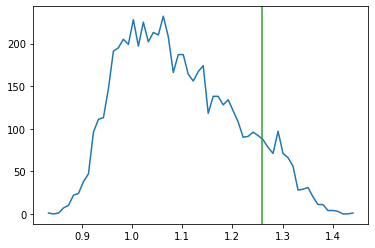

In [10]:
print(len(fval))
hist, bin_edges = np.histogram(fval, bins=len(fval)//100)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(bin_centers, hist)
plt.axvline(startval, color="C2")
plt.show()